Shape of the samples: torch.Size([10000, 2]) torch.Size([10000, 2])
Shape of the samples: torch.Size([10000, 2]) torch.Size([10000, 2])
--------------------------------------------------
model load success
--------------------------------------------------


/tmp/ipykernel_5681/3530795131.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rectified_flow_1.first_order_model.load_state_dict(torch.load(first_order_model_save_path

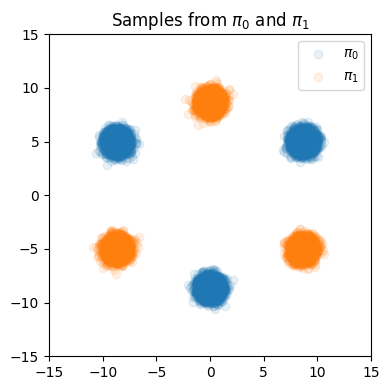

In [2]:

import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import wandb
import os
from train_gpu import MLP, MLP_2nd_order, RectifiedFlow


wandb_log_name = "second_order_v6"
ckpt_dir = "checkpoints"
input_dim = 2

D = 10.
M = D+5
VAR = 0.3
DOT_SIZE = 4
COMP = 3

initial_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
initial_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., D / 2.], [-D * np.sqrt(3) / 2., D / 2.], [0.0, - D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
initial_model = MixtureSameFamily(initial_mix, initial_comp)
samples_0 = initial_model.sample([10000])
target_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
target_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., - D / 2.], [-D * np.sqrt(3) / 2., - D / 2.], [0.0, D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
target_model = MixtureSameFamily(target_mix, target_comp)
samples_1 = target_model.sample([10000])
print('Shape of the samples:', samples_0.shape, samples_1.shape)

rectified_flow_1 = RectifiedFlow(first_order_model=MLP(input_dim, hidden_num=100), second_order_model=MLP_2nd_order(input_dim, hidden_num=100), num_steps=100)

save_dir = os.path.join(ckpt_dir, wandb_log_name)
first_order_model_save_path = os.path.join(save_dir, 'first_order_model.pt')
second_order_model_save_path = os.path.join(save_dir, 'second_order_model.pt')
rectified_flow_1.first_order_model.load_state_dict(torch.load(first_order_model_save_path))
rectified_flow_1.second_order_model.load_state_dict(torch.load(second_order_model_save_path))

print("-" * 50)
print("model load success")
print("-" * 50)





Outside num: 1383
Good ratio: 69.1500015258789%


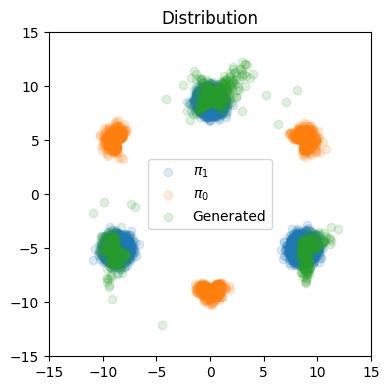

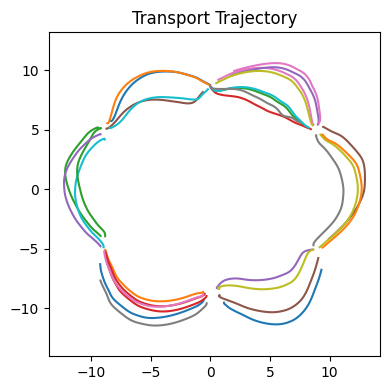

In [8]:
# draw plot code


def gen_overall_mask(traj):
    num_points = traj[0].shape[0]
    overall_mask = torch.ones(num_points, dtype=torch.bool)
    for point in traj:
        mask = (-5 <= point) & (point <= 5)
        mask = mask[:, 0] & mask[:, 1]
        # after this, we have inside = False, outside = True
        mask = ~mask
        overall_mask = overall_mask & mask
    return overall_mask

@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
    traj = rectified_flow.sample_ode(z0=z0, N=N)

    # rooll out inside, these code can be sanity check
    overall_mask = gen_overall_mask(traj)
    for i in range(len(traj)):
        traj[i] = traj[i][overall_mask]

    # count outside num
    outside_num = overall_mask.sum()
    print(f"Outside num: {outside_num}")
    total_num = z0.shape[0]
    good_ratio = outside_num / total_num
    # print in percetage way
    print(f"Good ratio: {good_ratio * 100}%")

    plt.figure(figsize=(4,4))
    plt.xlim(-M,M)
    plt.ylim(-M,M)

    #   print(traj[0][:, 1].cpu().numpy())
    #   raise
    save_fig_version_base = wandb_log_name.strip("second_order_")

    plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
    plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
    plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
    plt.legend()
    plt.title('Distribution')
    plt.tight_layout()
    fig_save_path = os.path.join("images", f"{save_fig_version_base}_scatter.png")
    plt.savefig(fig_save_path)

    traj_particles = torch.stack(traj)
    plt.figure(figsize=(4,4))
    plt.xlim(-M,M)
    plt.ylim(-M,M)
    plt.axis('equal')
    for i in range(30):
        plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
        plt.title('Transport Trajectory')
        plt.tight_layout()

    # savefigs
    fig_save_path = os.path.join("images", f"{save_fig_version_base}_traj.png")
    plt.savefig(fig_save_path)

#   plt.save(f"{wandb_log_name}.png")

draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=100)





In [3]:

z0=initial_model.sample([2000])
traj = rectified_flow_1.sample_ode(z0=z0, N=100)



In [4]:

def test_tensor(input_tensor):
    # input tensor shape: [2000, 2]
    mask = (-5 <= input_tensor) & (input_tensor <= 5)
    mask = mask[:, 0] & mask[:, 1]

    # True indicate inside, False indicate outside
    return mask

overall_mask = torch.ones(2000, dtype=torch.bool)
for point in traj:
    cur_mask = test_tensor(point)
    overall_mask = overall_mask & ~ cur_mask

print(f"Number of points outside the circle: {overall_mask.sum()}")




Number of points outside the circle: 1322
